In [164]:
import numpy as np
np.random.seed(0)

In [185]:


def calculate_optimal_theta(gamma=0.99, reward_vector=np.array([1, -1]), 
                           stationary_dist=np.array([0.5, 0.5]), 
                           feature_matrix=np.diag([np.sqrt(2), np.sqrt(2)])):
    """
    Calculate the optimal theta parameter for value function approximation in Markov Decision Processes.
    
    Parameters:
    -----------
    gamma : float
        Discount factor (between 0.5 and 1)
    reward_vector : np.array
        Reward vector for each state
    stationary_dist : np.array
        Stationary distribution of the Markov chain
    feature_matrix : np.array
        Feature matrix (Psi) for state representation
    
    Returns:
    --------
    tuple: (theta_opt, g_value)
        theta_opt: Optimal parameter vector
        g_value: Verification result (should be close to zero)
    """
    
    P = np.array([
        [(2*gamma - 1)/(1 - gamma), (1 - gamma)/gamma],
        [(1 - gamma)/gamma, (2*gamma - 1)/gamma]
    ])
    
    Pi = np.diag(stationary_dist)
    A = feature_matrix.T @ Pi @ feature_matrix - gamma * feature_matrix.T @ Pi @ P @ feature_matrix
    b = feature_matrix.T @ Pi @ reward_vector

    theta_opt = np.linalg.solve(A, b)
    def g(theta):
        return feature_matrix @ Pi @ (feature_matrix.T @ theta - reward_vector - gamma * P @ feature_matrix.T @ theta)
    
    g_value = g(theta_opt)
    
    return theta_opt, g_value

In [186]:
import matplotlib.pyplot as plt
def plot_training_loss(errors, log_scale=False, figsize=(10, 6), marker_every=10):
    """
    Plot training loss
    
    Parameters:
    - errors (array): Array of loss values per epoch
    - log_scale (bool): Whether to plot in logarithmic scale (default False)
    - figsize (tuple): Figure size (width, height) in inches
    - marker_every (int): Show markers every N epochs (0 to disable)
    """
    plt.figure(figsize=figsize)
    
    y_values = np.log(errors) if log_scale else errors
    y_label = 'ln(Loss)' if log_scale else 'Loss'

    line = plt.plot(y_values, 
                   color='#2e7f9e',
                   linewidth=2.5,
                   alpha=0.9,
                   marker='o' if marker_every > 0 else None,
                   markersize=4,
                   markevery=marker_every)
    
    title = 'Training Loss' + (' (Log Scale)' if log_scale else '')
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    plt.grid(True, linestyle='--', color='lightgray', alpha=0.7)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)
    
    final_epoch = len(errors)-1
    final_value = y_values[-1]
    plt.scatter(final_epoch, final_value, color='#d62728', zorder=5, s=80)
    plt.text(final_epoch+0.5, final_value, f'{final_value:.4f}', 
             color='#d62728', fontsize=10, va='center')
    
    plt.tight_layout()
    plt.show()

In [214]:
from typing import Tuple, List, Callable
from tqdm import tqdm

class VRTD:
    def __init__(self, 
                 feature_dim: int, 
                 state_dim: int,
                 gamma: float,
                 eta: float,
                 epochs: int,
                 epoch_length: int,
                 initial_N: int):
        """
        Инициализация алгоритма VRTD
        
        Параметры:
            feature_dim: размерность признакового пространства
            state_dim: количество состояний
            gamma: коэффициент дисконтирования
            eta: размер шага
            epochs: количество эпох
            epoch_length: длина эпохи (T)
            initial_N: начальное количество выборок для оценки оператора
        """
        self.d = feature_dim
        self.D = state_dim
        self.gamma = gamma
        self.eta = eta
        self.initial_eta = eta
        self.K = epochs
        self.T = epoch_length
        self.N = initial_N
        self.errors = []
        
        self.theta = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)
        self.Psi = None
        
    def set_feature_matrix(self, Psi: np.ndarray):
        assert Psi.shape == (self.D, self.d)
        self.Psi = Psi
        
    def compute_g(self, theta: np.ndarray, xi: Tuple[int, int, float]) -> np.ndarray:
        """        
        xi: кортеж (s, s', R(s,s'))
        """
        s, s_prime, r = xi
        psi_s = self.Psi[s]
        psi_s_prime = self.Psi[s_prime]
        return (np.dot(psi_s, theta) - r - self.gamma * np.dot(psi_s_prime, theta)) * psi_s
        
    def run_epoch(self, k: int, sample_generator: Callable[[], Tuple[int, int, float]]):
        """
            k: номер эпохи
            sample_generator: генератор выборок (s, s', R(s,s'))
        """
        self.theta_hat = self.theta.copy()
        N_k = self.N
        g_hat = np.zeros(self.d)
        for _ in range(N_k):
            xi = sample_generator()
            g_hat += self.compute_g(self.theta_hat, xi)
        g_hat /= N_k
        
        theta_sequence = []
        
        for t in range(self.T):
            xi = sample_generator()
            g_current = self.compute_g(self.theta, xi)
            g_hat_sample = self.compute_g(self.theta_hat, xi)
            self.theta -= self.eta * (g_current - g_hat_sample + g_hat)
            theta_sequence.append(self.theta.copy())
        
        theta_sequence.append(self.theta.copy())
        self.theta = np.mean(np.array(theta_sequence), axis=0)
        
    def train(self, sample_generator: Callable[[], Tuple[int, int, float]], theta_opt):
        """
            sample_generator: генератор выборок (s, s', R(s,s'))
        """
        for k in tqdm(range(self.K)):
            self.run_epoch(k, sample_generator)
            self.errors.append(np.linalg.norm(theta_opt - self.theta))
            # self.eta = self.initial_eta/(k+1)**2
            # if k % 10 == 0:
            #     self.eta /= 2
            
        return self.errors
            
    def get_value_function(self) -> np.ndarray:
        """Получение оцененной функции ценности"""
        return self.Psi @ self.theta

In [215]:
import numpy as np
import matplotlib.pyplot as plt

def run_vrtd_experiment(gamma=0.99, D=2, d=2, epochs=100, epoch_length=900, initial_N=100):
    """
    Run complete VRTD experiment with given parameters and visualize results.
    
    Parameters:
    -----------
    gamma : float
        Discount factor (0.99 by default)
    D : int
        State space dimension (2 by default)
    d : int
        Feature dimension (2 by default)
    epochs : int
        Number of training epochs
    epoch_length : int
        Length of each epoch
    initial_N : int
        Initial batch size
    
    Returns:
    --------
    dict: Dictionary containing all experiment results
    """
    theta_opt, verification = calculate_optimal_theta(gamma=gamma)
    # print(f"Optimal theta: {theta_opt}")
    # print(f"Verification: {verification} (should be close to [0, 0])")

    Psi = np.diag([np.sqrt(2), np.sqrt(2)])
    pi = np.ones(D)/D
    P = np.array([
        [(2*gamma - 1)/gamma, (1 - gamma)/gamma],
        [(1 - gamma)/gamma, (2*gamma - 1)/gamma]
    ])
    r = np.array([1, -1])
    
    vrtd = VRTD(
        feature_dim=d,
        state_dim=D,
        gamma=gamma,
        eta=(24 * (1 - gamma))/((1+gamma)**2),
        epochs=epochs,
        epoch_length=epoch_length,
        initial_N=initial_N
    )
    vrtd.set_feature_matrix(Psi)
    
    def sample_generator():
        s = np.random.choice([0, 1], p=[0.5, 0.5])
        s_prime = np.random.choice([0, 1], p=P[s])
        reward = r[s]
        return (s, s_prime, reward)
    
    errors = vrtd.train(sample_generator, theta_opt)
    
    V_hat = vrtd.get_value_function()
    # print(f"\nEstimated value function: {V_hat}")

    return  errors

100%|██████████| 50/50 [01:44<00:00,  2.08s/it]


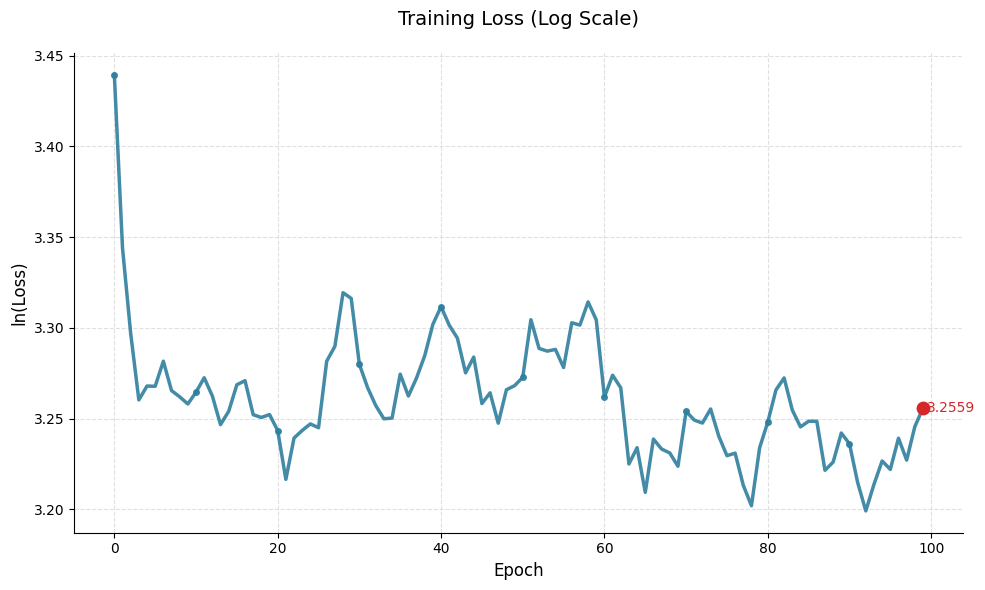

In [225]:
stats = []
for x in tqdm(range(50)):
    errors = run_vrtd_experiment(
            gamma=0.99,
            epochs=100,
            epoch_length=250,
            initial_N=250
        )

    # plot_training_loss(errors, log_scale=True)
    stats.append(errors)
results = np.mean(stats, axis=0)
plot_training_loss(results, log_scale=True)

100%|██████████| 50/50 [08:40<00:00, 10.41s/it]


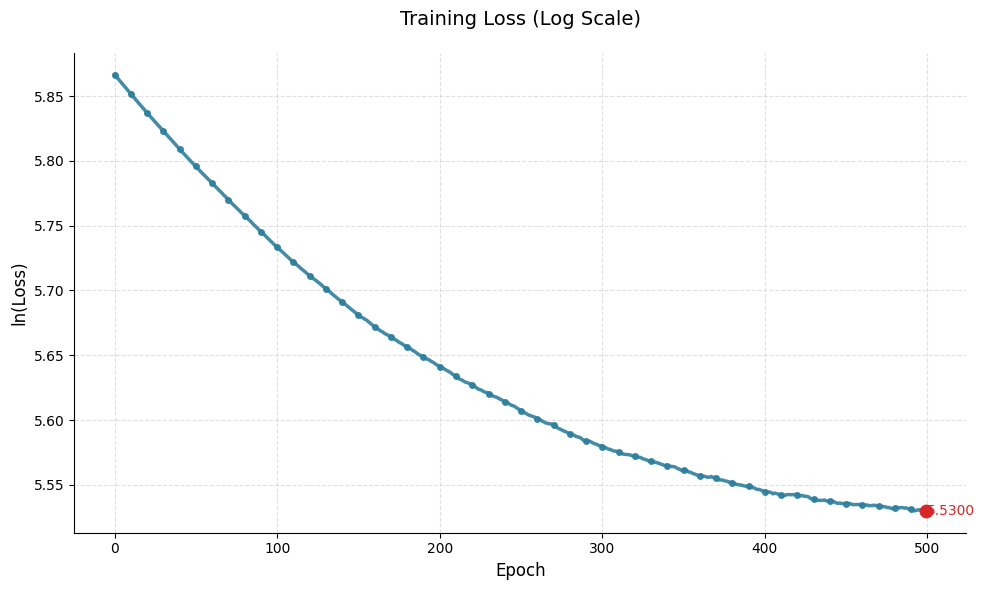

In [227]:
stats = []
for x in tqdm(range(50)):
    errors = run_vrtd_experiment(
            gamma=0.999,
            epochs=500,
            epoch_length=250,
            initial_N=250
        )

    # plot_training_loss(errors, log_scale=True)
    stats.append(errors)
results = np.mean(stats, axis=0)
plot_training_loss(results, log_scale=True)

100%|██████████| 10000/10000 [25:26<00:00,  6.55it/s]


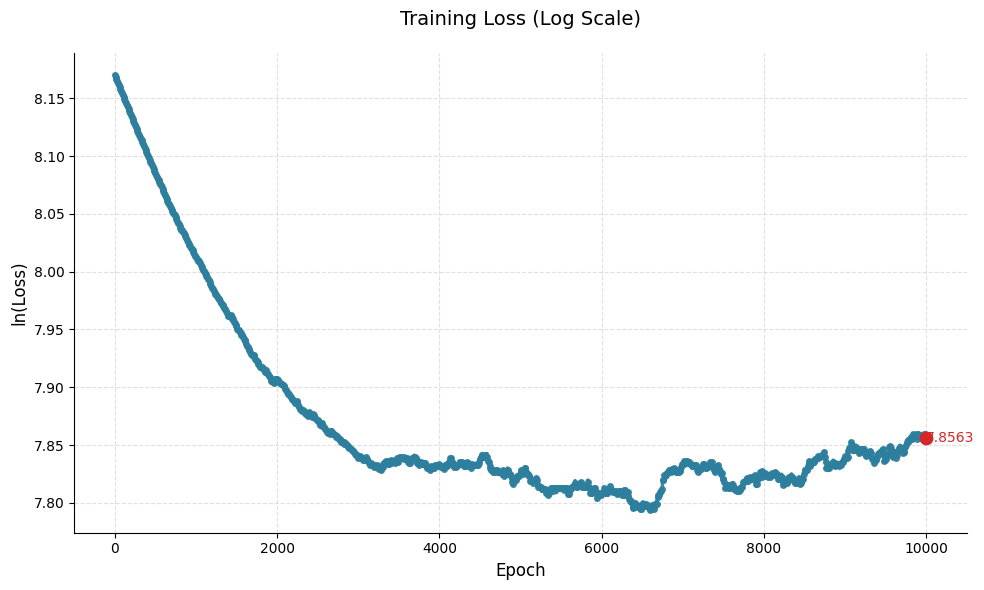

In [237]:
errors = run_vrtd_experiment(
            gamma=0.9999,
            epochs=10000,
            epoch_length=3000,
            initial_N=1000
        )
plot_training_loss(errors, log_scale=True)

100%|██████████| 10000/10000 [21:22<00:00,  7.80it/s]


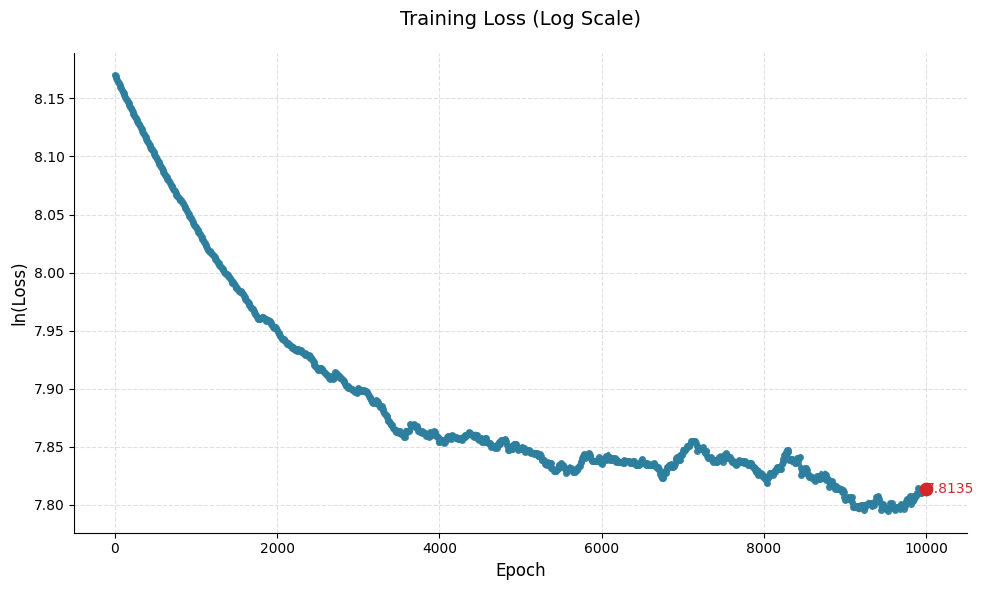

In [238]:
errors = run_vrtd_experiment(
            gamma=0.9999,
            epochs=10000,
            epoch_length=2500,
            initial_N=800
        )
plot_training_loss(errors, log_scale=True)